In [47]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [48]:
data = pd.read_csv("https://www.gasnetworks.ie/corporate/open-data/2024-Q3-Daily-Gas-Demand.csv")

# renaming columns
data.columns = ['date','l_business','xs_business_houses','xl_business','power_gen','total']

# Rounding the data to 2 decimal places
data = data.round(2)

# Formatting the date column
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')

In [49]:
# Monthly gas consumption 
month_houses = data.groupby(data['date'].dt.to_period('M')).mean()

# Monthly gas consumption for houses and xs business
month_houses = month_houses.drop(columns=['date','xl_business','power_gen','total','l_business'])
month_houses=month_houses.reset_index()
month_houses['date'] = month_houses['date'].dt.to_timestamp()

print(month_houses['date'].min())
print(month_houses['date'].max())

2018-01-01 00:00:00
2024-09-01 00:00:00


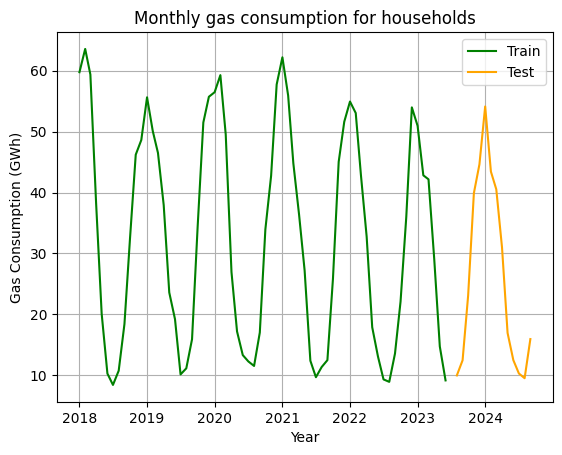

In [50]:
# set date as index
month_houses = month_houses.set_index('date')

month_houses = month_houses.asfreq('MS')
month_houses = month_houses.sort_index()
month_houses

# Splitting data for traning and testing
# Data before 2023-07-01 will be the training one. 

train = month_houses[month_houses.index < pd.to_datetime("2023-07-01", format='%Y-%m-%d')]
test = month_houses[month_houses.index > pd.to_datetime("2023-07-01", format='%Y-%m-%d')]

# plotting train and test
fig,ax =plt.subplots()
ax.plot(train.index,train['xs_business_houses'],color = 'green' ,label='Train')
ax.plot(test.index,test['xs_business_houses'],color='orange', label='Test')
ax.set_xlabel("Year")
ax.set_ylabel("Gas Consumption (GWh)")
ax.set_title("Monthly gas consumption for households")
ax.grid()
ax.legend(loc='upper right')
plt.show()

In [51]:
# Verifying that a temporary index is complete
start_date = month_houses.index.min()
end_date = month_houses.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=month_houses.index.freq)
is_index_complete = (month_houses.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")

# Missing values
print(f'Number of rows with missing values: {month_houses.isnull().any(axis=1).mean()}')

Index complete: True
Number of rows with missing values: 0.0


In [52]:
# Verifying that a temporary index is complete for train data
start_date = train.index.min()
end_date = train.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=train.index.freq)
is_index_complete = (train.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")

# Missing values
print(f'Number of rows with missing values: {train.isnull().any(axis=1).mean()}')

Index complete: True
Number of rows with missing values: 0.0


In [53]:
# This function checks date for stationary for Train data
# Ref.:https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


check_stationarity(train['xs_business_houses'])

ADF Statistic: -0.1626058820403203
p-value: 0.9428345837792915
Non-Stationary


In [54]:
# Differencing the Data
# Differencing involves subtracting the previous observation from
# the current observation to remove trends and seasonality.

# First-order differencing
train = train.diff()

# Drop the first row with NaN
diff_train = train.dropna()

# Check stationarity again
check_stationarity(diff_train)

ADF Statistic: -6.038874788232786
p-value: 1.361085318430713e-07
Stationary


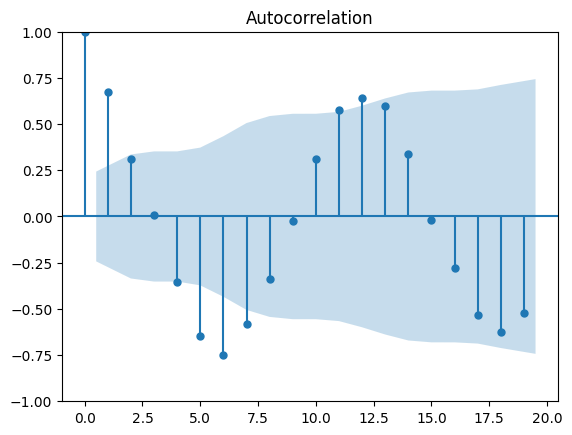

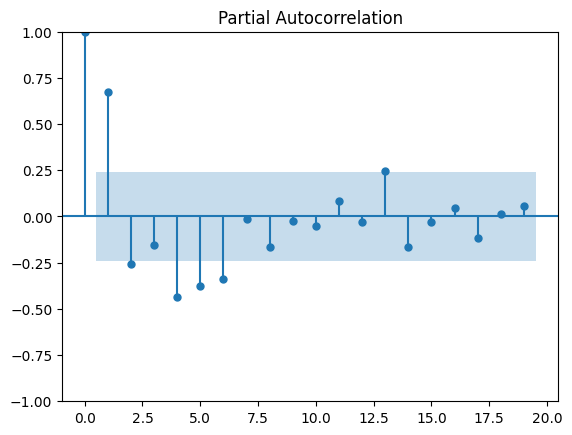

In [55]:
# Plot ACF and PACF
plot_acf(diff_train)
plot_pacf(diff_train)
plt.show()

In [56]:
# Define SARIMA parameters
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12  # Assuming monthly seasonality

# Fit the SARIMA model
model = SARIMAX(diff_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
model

/Users/katelisovenko/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60144D+00    |proj g|=  1.00449D-01

At iterate    5    f=  2.49622D+00    |proj g|=  5.25557D-02

At iterate   10    f=  2.47356D+00    |proj g|=  9.86784D-04

At iterate   15    f=  2.47298D+00    |proj g|=  3.84180D-03

At iterate   20    f=  2.47247D+00    |proj g|=  2.89813D-03

At iterate   25    f=  2.47241D+00    |proj g|=  7.24382D-04

At iterate   30    f=  2.47240D+00    |proj g|=  9.28272D-05

At iterate   35    f=  2.47240D+00    |proj g|=  6.46282D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [ ]:
# Forecast future values
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast

plt.figure(figsize=(12, 6))
plt.plot(diff_series, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green')
plt.title("Household gas consumption forecast")
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.legend()
plt.show()